**필요한 라이브러리 호출**

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm.notebook import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
import time
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**이미지 데이터셋 전처리**

In [3]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transfrom = {
            "train" : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val" : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transfrom[phase](img)

**이미지 데이터셋을 불러온 후 훈련, 검즘, 테스트로 분리**

In [4]:
cat_directory = r'../pytorch/data/dogs-vs-cats/Cat/'
dog_directory = r'../pytorch/data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
imgaes_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in imgaes_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


**테스트 데이터셋 이미지 확인 함수**

In [5]:
def display_image_grid(imgaes_filepaths, predicted_labels = (), cols = 5):
    rows = len(imgaes_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(imgaes_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath)
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()

**테스트 데이터셋 이미지를 출력**

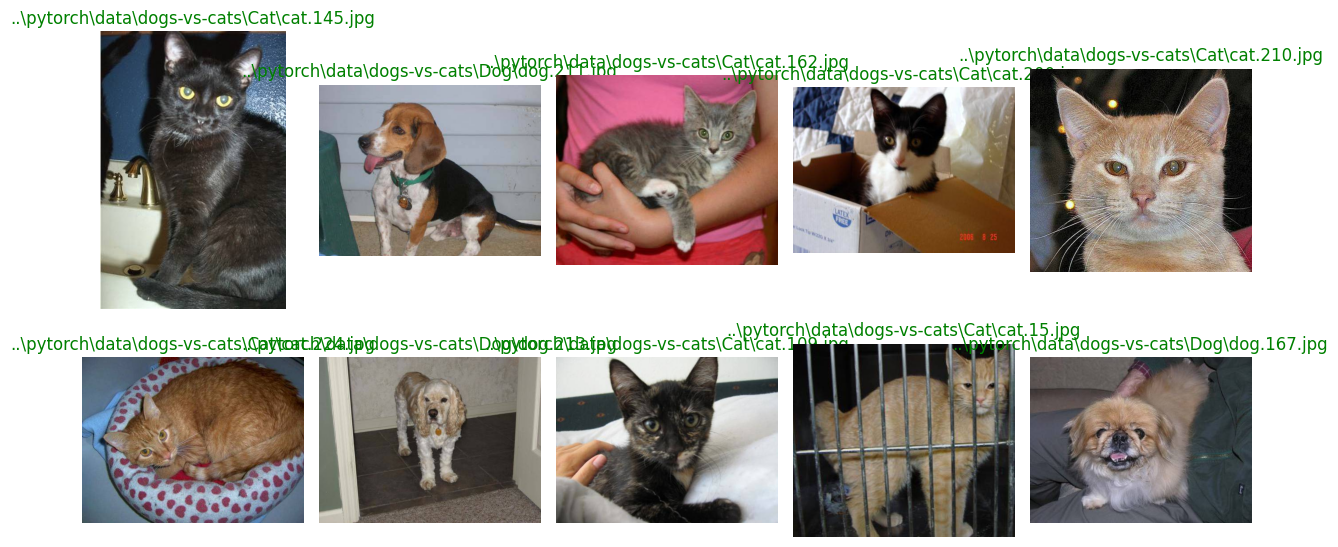

In [6]:
display_image_grid(test_images_filepaths)

**이미지 데이터셋 클래스 정의**

In [7]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform = None, phase = "train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split("/")[-1].split(".")[0]
        
        if label == "dog":
            label = 1
        elif label == "cat":
            label = 0
        
        return img_transformed, label

**변수 값 정의**

In [8]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

**이미지 데이터셋 정의**

In [9]:
train_dataset = DogvsCatDataset(train_images_filepaths,
                                transform=ImageTransform(size, mean, std),
                                phase="train")
val_dataset = DogvsCatDataset(val_images_filepaths,
                              transform=ImageTransform(size, mean, std),
                              phase="val")
index = 0

print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


**데이터로더 정의**

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {"train" : train_dataloader, "val" : val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)

print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1])


**모델의 네트워크 클래스**

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        
        return out

**모델 객체 생성**

In [12]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


**torchsummary 라이브러리를 이용한 모델의 네트워크 구조 확인**

In [13]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

**학습 가능한 파라미터 수 확인**

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 46,038,242 trainable parameters


**옵티마이저와 손실 함수 정의**

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

**모델의 파라미터와 손실 함수를 CPU에 할당**

In [16]:
model = model.to(device)
criterion = criterion.to(device)

**모델 학습 함수 정의**

In [17]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print(f"Epoch {epoch + 1}/{num_epoch}")
        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
                epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
                epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

                print("{} loss : {:.4f} Acc : {:.4f}".format(phase, epoch_loss, epoch_acc))

                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

        time_elapsed = time.time() - since
        print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
        print("Best val Acc : {:.4f}".format(best_acc))
        return model

**모델 학습**

In [18]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train loss : 0.0548 Acc : 0.0450
train loss : 0.0551 Acc : 0.0875
train loss : 0.0560 Acc : 0.1300
train loss : 0.0561 Acc : 0.1675
train loss : 0.0558 Acc : 0.2000
train loss : 0.0555 Acc : 0.2450
train loss : 0.0552 Acc : 0.2925
train loss : 0.0554 Acc : 0.3350
train loss : 0.0554 Acc : 0.3775
train loss : 0.0557 Acc : 0.4200
train loss : 0.0545 Acc : 0.4650
train loss : 0.0560 Acc : 0.5025
train loss : 0.0303 Acc : 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val loss : 0.2470 Acc : 0.1304
val loss : 0.2432 Acc : 0.3043
val loss : 0.2219 Acc : 0.4239
Training complete in 0m 6s
Best val Acc : 0.4239


**모델 테스트를 위한 함수 정의**

In [19]:
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split("/")[-1].split(".")[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase="val")
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        
    res = pd.DataFrame({
        "id" : id_list,
        "label" : pred_list
    })

    res.sort_values(by="id", inplace=True)
    res.reset_index(drop=True, inplace=True)

    res.to_csv("../pytorch/data/LeNet.csv", index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

**테스트 데이터셋의 예측 결과 호출**

In [20]:
res.head(10)

,id,label
0,109,0.471436
1,145,0.434751
2,15,0.433281
3,162,0.468106
4,167,0.469732
5,200,0.453796
6,210,0.488393
7,211,0.472016
8,213,0.455042
9,224,0.478478


**테스트 데이터셋 이미지를 출력하기 위한 함수 정의**

In [21]:
class_ = classes = {0 : "cat", 1 : "dog"}
def display_image_grid2(imgaes_filepaths, predicted_labels=(), cols=5):
    rows = len(imgaes_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    
    for i, imgae_filepath in enumerate(imgaes_filepaths):
        image = cv2.imread(imgae_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res["id"].values)
        label = res.loc[res["id"] == a, "label"].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()

**테스트 데이터셋 예측 결과 이미지 출력**

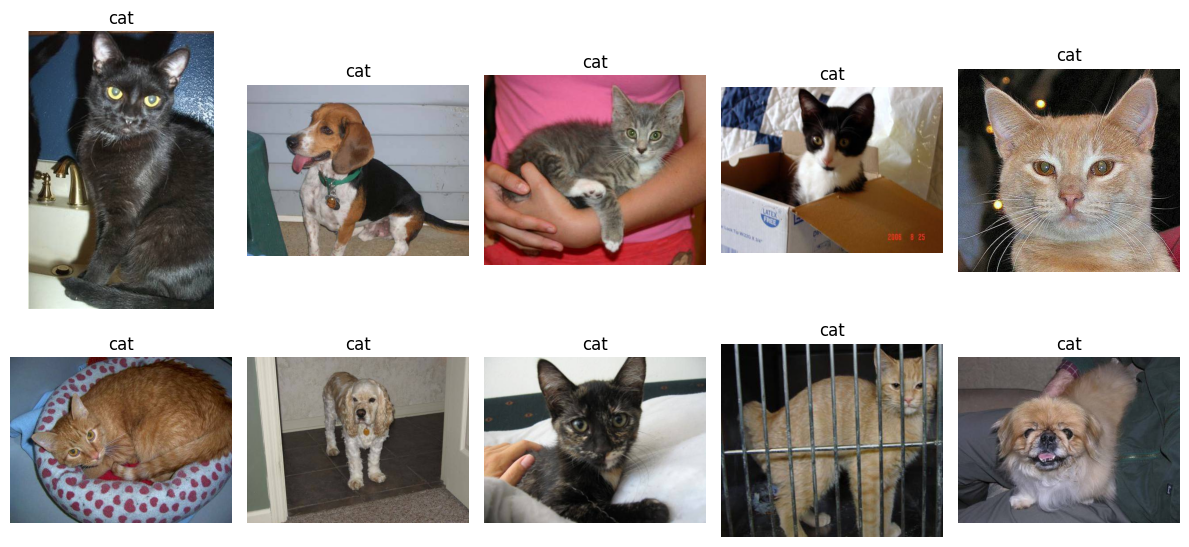

In [22]:
display_image_grid2(test_images_filepaths)